In [1]:
import os
os.chdir("..")
os.getcwd()

'/Users/laurasisson/odor-pair'

In [2]:
import json
with open("dataset/full.json") as f:
    full_data = json.load(f)

In [6]:
full_canonize = dict()

CANONIZE_DICTIONARY = {
    "":None,
    "No odor group found for these":None,
    "anisic":"anise",
    "corn chip":"corn",
    "medicinal,":"medicinal",
}

full_canonize.update(CANONIZE_DICTIONARY)

In [52]:
def canonize_note(note):
    while note in full_canonize:
        note = full_canonize[note]
    return note

def canonize(notes):
    cleaned = set()
    for n in notes:
        canonized = canonize_note(n)
        if canonized:
            cleaned.add(canonized)
    return sorted(list(cleaned))

In [53]:
import collections
cooccurrence = collections.defaultdict(collections.Counter)
for ds in full_data:
    ns = canonize(ds["blend_notes"])
    for n1 in ns:
        for n2 in ns:
            cooccurrence[n1][n2] += 1
        

In [54]:
cooccurrence.keys()

dict_keys(['animal', 'fruity', 'waxy', 'berry', 'caramellic', 'jammy', 'chemical', 'tropical', 'citrus', 'green', 'earthy', 'fatty', 'ethereal', 'fermented', 'fusel', 'floral', 'honey', 'estery', 'herbal', 'melon', 'sulfurous', 'vanilla', 'aldehydic', 'amber', 'balsamic', 'phenolic', 'chocolate', 'creamy', 'medicinal', 'cherry', 'musk', 'spicy', 'tonka', 'woody', 'aromatic', 'minty', 'winey', 'acidic', 'sweet', 'anise', 'buttery', 'cocoa', 'coconut', 'dairy', 'powdery', 'musty', 'thujonic', 'mushroom', 'camphoreous', 'mentholic', 'soapy', 'alliaceous', 'cooling', 'nutty', 'fungal', 'leathery', 'marine', 'mossy', 'smoky', 'juicy', 'tomato', 'vegetable', 'coffee', 'rummy', 'potato', 'malty', 'onion', 'roasted', 'bitter', 'cheesy', 'oily', 'pungent', 'burnt', 'licorice', 'orris', 'garlic', 'brown', 'meaty', 'tobacco', 'eggy', 'solvent', 'clean', 'bready', 'sour', 'toasted', 'fishy', 'coumarinic', 'corn', 'mustard', 'moldy', 'fresh', 'cabbage', 'alcoholic', 'celery', 'lactonic', 'rooty', '

In [55]:
import pandas as pd
df = pd.DataFrame(cooccurrence).fillna(0)

# Sort columns by the sum of their values in descending order
df = df[df.max().sort_values(ascending=False).index]

# Sort rows by the sum of their values in descending order
df = df.loc[df.columns]

for p1, p2 in zip(df.index.to_list(), df.columns.to_list()):
    assert p1 == p2

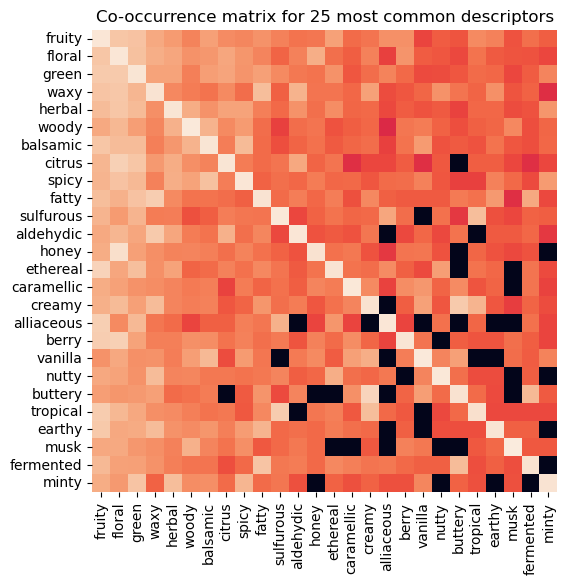

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors


df_norm = df.div(df.sum(axis=1), axis=0)
df_norm.div(df_norm.sum(axis=0), axis=1)
df_norm = df_norm+1e-9

n = 25

size = 6
# Resize the heatmap
plt.figure(figsize=(size, size))  # Adjust the figsize as needed

log_norm = mcolors.LogNorm(vmin=df_norm.min().min(), vmax=df_norm.max().max())

# Create the heatmap
ax = sns.heatmap(df_norm.iloc[:n+1,:n+1],cbar=False, norm=mcolors.LogNorm(), xticklabels=True, yticklabels=True)
# Adjust the position of the heatmap to ensure all labels are visible

plt.title(f"Co-occurrence matrix for {n} most common descriptors")
plt.show()


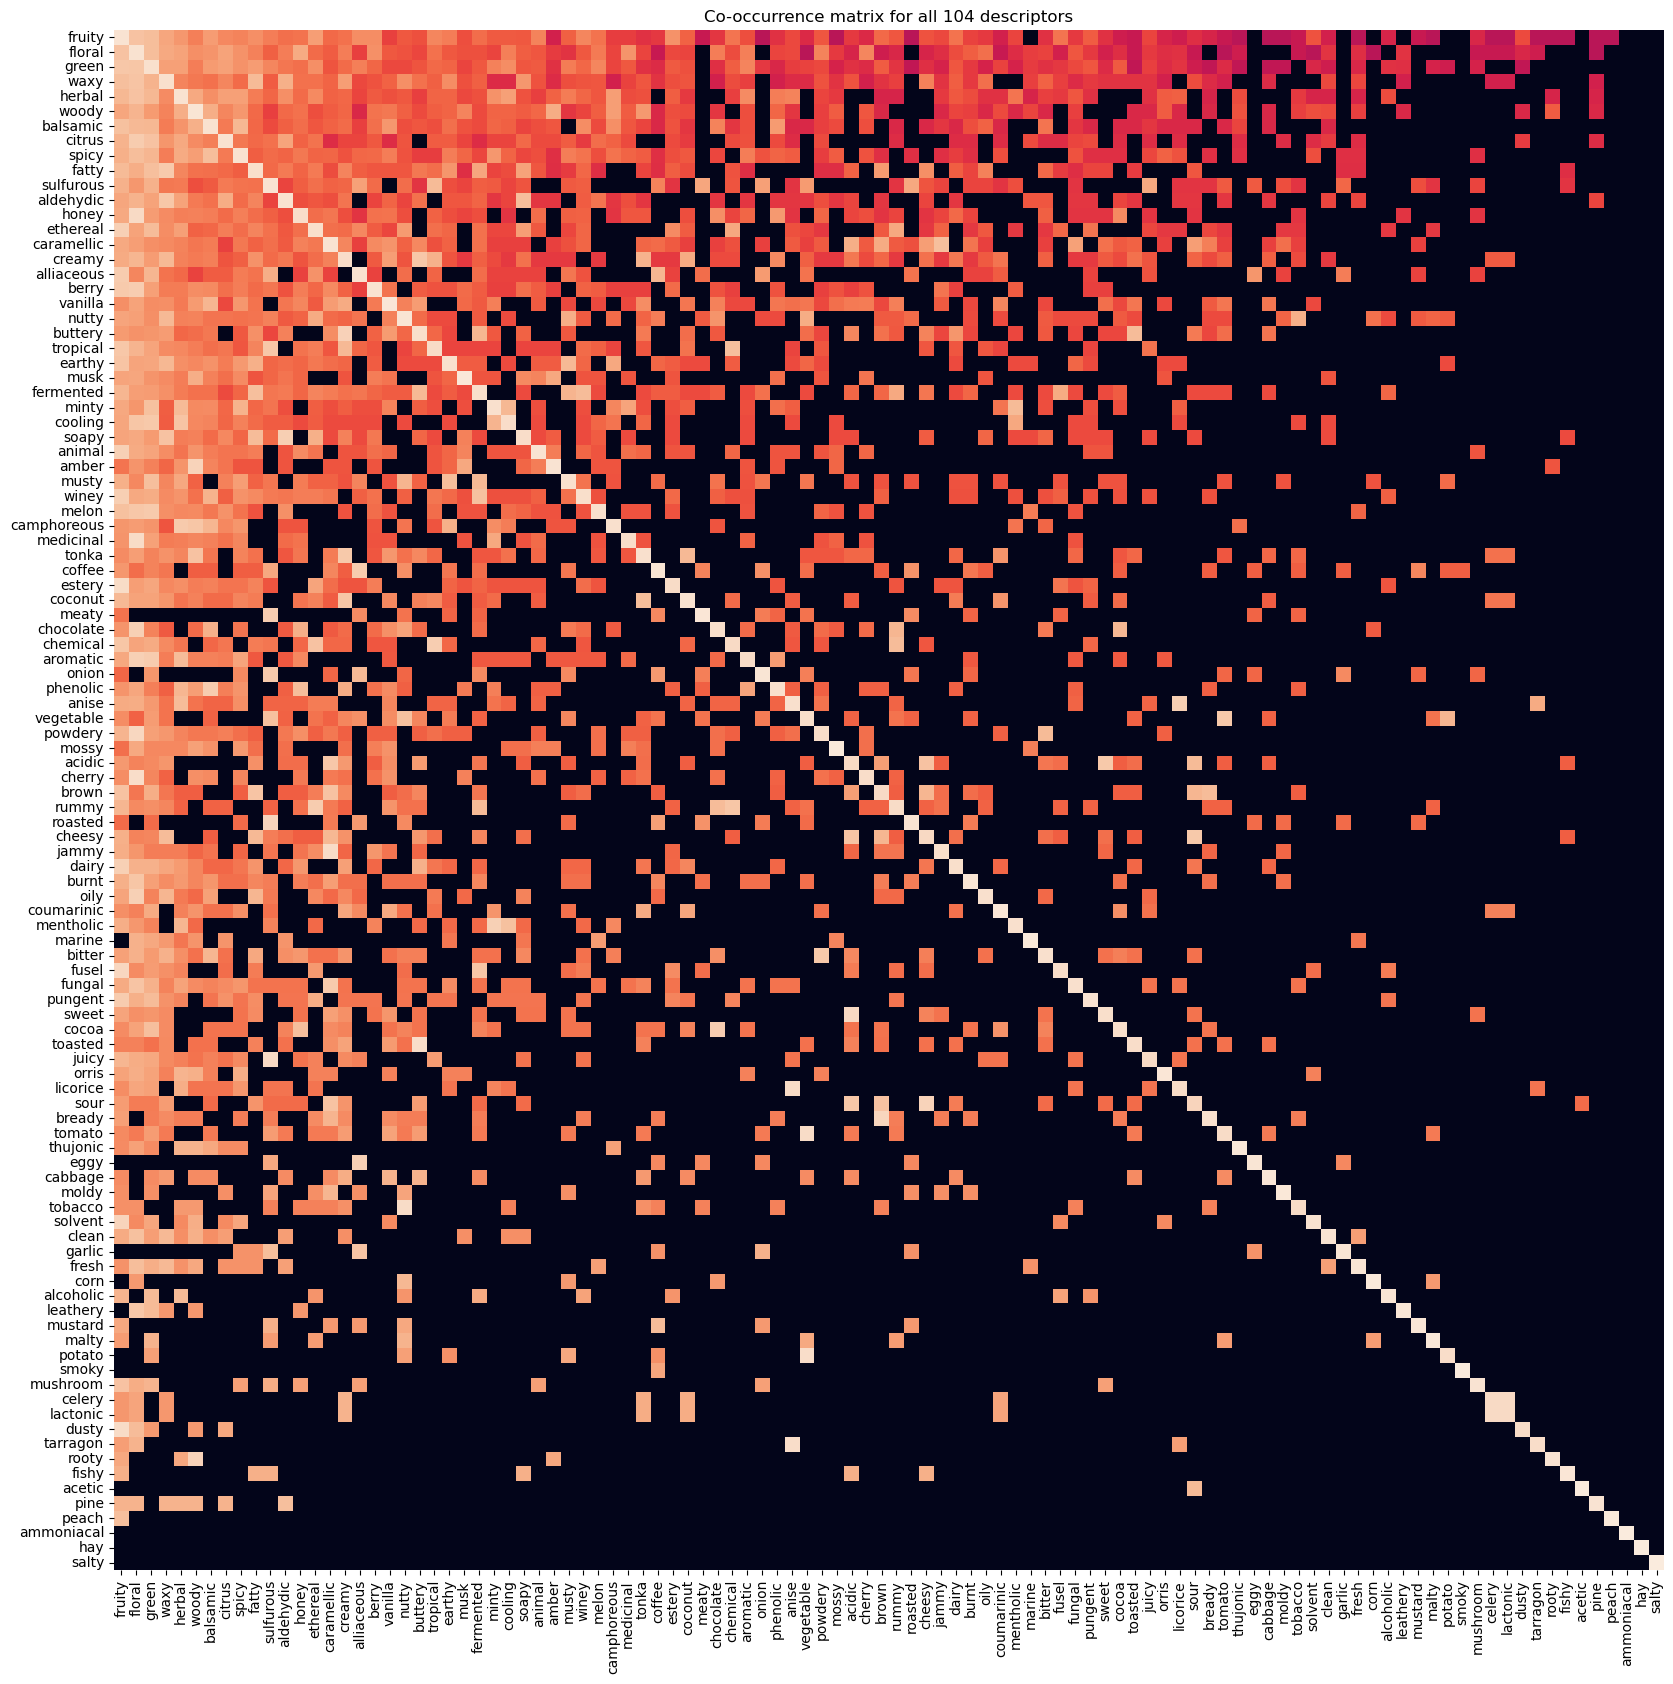

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors


df_norm = df.div(df.sum(axis=1), axis=0)
df_norm.div(df_norm.sum(axis=0), axis=1)
df_norm = df_norm+1e-9

size = 20
# Resize the heatmap
plt.figure(figsize=(size, size))  # Adjust the figsize as needed

log_norm = mcolors.LogNorm(vmin=df_norm.min().min(), vmax=df_norm.max().max())

# Create the heatmap
ax = sns.heatmap(df_norm,cbar=False, norm=mcolors.LogNorm(), xticklabels=True, yticklabels=True)
# Adjust the position of the heatmap to ensure all labels are visible

plt.title(f"Co-occurrence matrix for all {len(df_norm.index)} descriptors")
plt.show()


In [58]:
# Get a list of row indices for each column that contains the maximum value
max_row_indices = df.apply(lambda x: x[x == x.max()].index.tolist())

subsets = dict()
count = 0
for p1, hits in list(zip(df.index,max_row_indices)):
    if len(hits) == 1:
        continue
    hits.remove(p1)
    assert len(hits) == 1
    parent = hits[0]
    subsets[f"'{p1}'"] = {"Parent Note":f"'{parent}'","Frequency":cooccurrence[p1][p1]}
    assert cooccurrence[p1][p1] == cooccurrence[p1][parent]
    count += 1
subsets,count

({"'estery'": {'Parent Note': "'fruity'", 'Frequency': 739},
  "'cherry'": {'Parent Note': "'floral'", 'Frequency': 443},
  "'toasted'": {'Parent Note': "'buttery'", 'Frequency': 218},
  "'juicy'": {'Parent Note': "'sulfurous'", 'Frequency': 185},
  "'tomato'": {'Parent Note': "'vegetable'", 'Frequency': 138},
  "'tobacco'": {'Parent Note': "'nutty'", 'Frequency': 101},
  "'potato'": {'Parent Note': "'vegetable'", 'Frequency': 51},
  "'celery'": {'Parent Note': "'lactonic'", 'Frequency': 34},
  "'lactonic'": {'Parent Note': "'celery'", 'Frequency': 34},
  "'dusty'": {'Parent Note': "'fruity'", 'Frequency': 32},
  "'tarragon'": {'Parent Note': "'anise'", 'Frequency': 28}},
 11)

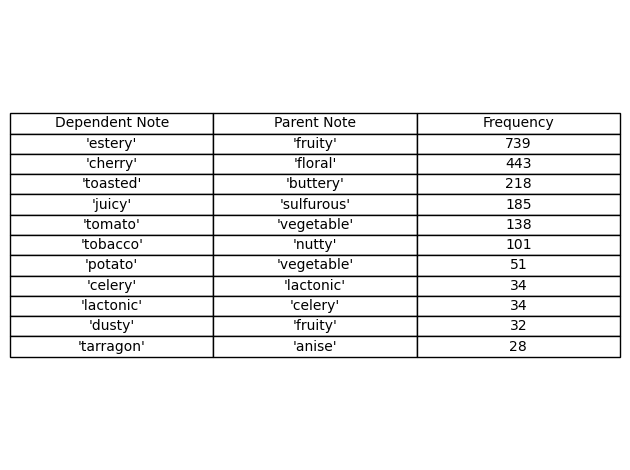

In [59]:
# Create a DataFrame from the given data
parents_df = pd.DataFrame(subsets).transpose()
parents_df.index.name = 'Dependent Note'

# Plot the DataFrame as a matplotlib table
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis

cell_text = [[parents_df.index.name] + list(parents_df.columns)] + parents_df.reset_index().values.tolist()

table = ax.table(cellText=cell_text,
                  loc='center',
                  cellLoc='center')
plt.tight_layout()
plt.show()


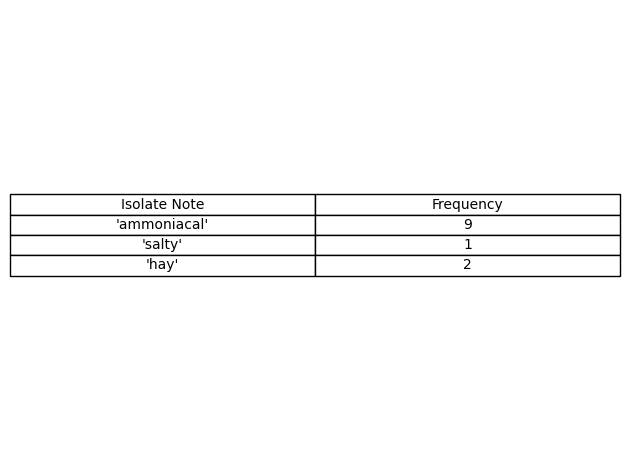

,Frequency
Isolate Note,
'ammoniacal',9
'salty',1
'hay',2


In [60]:
isolate_notes = {f"'{k}'":{"Frequency":cooccurrence[k][k]} for k in cooccurrence.keys() if len(cooccurrence[k]) == 1}

# Create a DataFrame from the given data
isolate_df = pd.DataFrame(isolate_notes).transpose()
isolate_df.index.name = 'Isolate Note'

# Plot the DataFrame as a matplotlib table
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis

cell_text = [[isolate_df.index.name] + list(isolate_df.columns)] + isolate_df.reset_index().values.tolist()

table = ax.table(cellText=cell_text,
                  loc='center',
                  cellLoc='center')
plt.tight_layout()
plt.show()
isolate_df

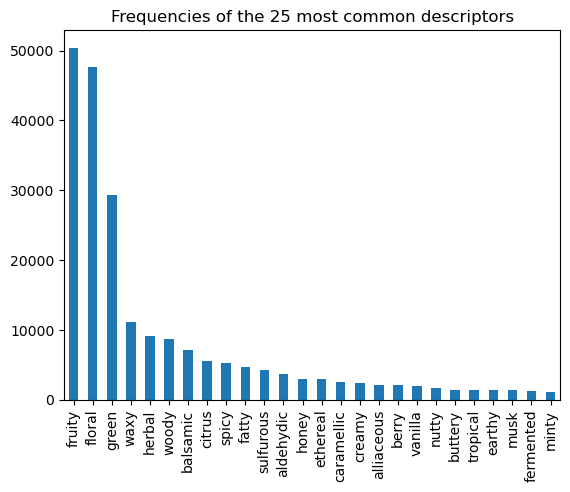

In [61]:
size = 15
# Resize the heatmap
# plt.figure(figsize=(size, size))  # Adjust the figsize as needed
n = 25
df.max().iloc[:n+1].plot(kind="bar")
plt.title(f"Frequencies of the {n} most common descriptors")
plt.show()

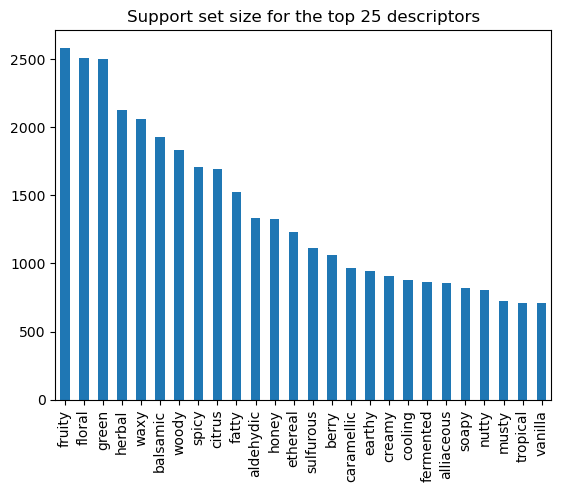

In [62]:
import collections
underlying = collections.defaultdict(set)
for ds in full_data:
    ns = canonize(ds["blend_notes"])
    for n in ns:
        underlying[n].add(ds["mol1"])
        underlying[n].add(ds["mol2"])
underyling = {k:{"Size":len(v)} for k, v in underlying.items()}
underyling_df = pd.DataFrame(underyling).transpose().sort_values("Size",ascending=False)

n = 25
underyling_df.iloc[:n+1].plot(kind="bar",legend=False)
plt.title(f"Support set size for the top {n} descriptors")
plt.show()

In [64]:
underyling_df

,Size
fruity,2584
floral,2508
green,2498
herbal,2126
waxy,2057
...,...
pine,14
peach,11
ammoniacal,10
hay,3


In [63]:
density = collections.Counter({note:cooccurrence[note][note]/underyling[note]["Size"] for note in underlying.keys()})
density.most_common()

[('fruity', 19.50812693498452),
 ('floral', 18.990031897926634),
 ('green', 11.759407526020818),
 ('waxy', 5.392318911035488),
 ('woody', 4.742374727668845),
 ('herbal', 4.3071495766698025),
 ('sulfurous', 3.7956795679567956),
 ('balsamic', 3.6588785046728973),
 ('citrus', 3.278533412182141),
 ('spicy', 3.0941520467836257),
 ('fatty', 3.070209973753281),
 ('buttery', 2.767857142857143),
 ('aldehydic', 2.7107438016528924),
 ('meaty', 2.6980392156862747),
 ('vanilla', 2.678420310296192),
 ('creamy', 2.6288546255506606),
 ('caramellic', 2.569055036344756),
 ('amber', 2.5213270142180093),
 ('alliaceous', 2.473193473193473),
 ('musk', 2.4232902033271717),
 ('ethereal', 2.3959349593495936),
 ('honey', 2.2626034612490593),
 ('onion', 2.1620553359683794),
 ('nutty', 2.0935162094763093),
 ('berry', 1.9933899905571293),
 ('coconut', 1.934959349593496),
 ('tropical', 1.9325842696629214),
 ('coffee', 1.7914798206278026),
 ('camphoreous', 1.7739307535641549),
 ('minty', 1.7149187592319055),
 ('acid